说明：泰坦尼克号乘船事件，都是大家所熟知的历史事件，就不多述说事情起因了

我们的目的，就是通过此次事件，通过乘客的信息来预测人员的存活率。这也是一个典型的分类预测问题。

这里还是以特征入手，我们看下面的特征很少

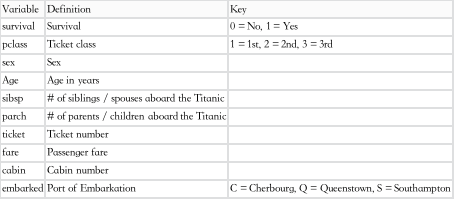

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

很可能到后面我们还需要用到组合特征来提高预测的准确率

还是老样子，先加载数据，然后来看看数据的情况，是否存在异常值，缺失值等。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
def loaddata(file, train=True):
    if train:
        data_train = pd.read_csv(file)
        return data_train
    else:
        data_test = pd.read_csv(file)
        return data_test

In [3]:
data_train = loaddata('./数据集/train.csv')
data_test = loaddata('./数据集/test.csv')

data_train.drop('Ticket', inplace=True, axis=1)
data_test.drop('Ticket', inplace=True, axis=1)

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 32.7+ KB


很明显存在缺失值，需要补全，方法还是采用预测补全，异常值这边就不看了，就这么几个数据，也看不出个什么异常值。同时，这边对于数据缺失过多的，也不丢弃了，全部都用上。

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
X_train = data_train[data_train.columns[2:]]
y_train = data_train[data_train.columns[1]]

X_test = data_test[data_test.columns[1:]]

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

le = LabelEncoder()
y_train = le.fit_transform(y_train)

先对缺失数据补全，类别数据替换为NaN，数值替换为0；再进行类比转换。

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
def fillna(X):
    for i in X.columns:
        if X[i].dtype == 'O':
            X[i].fillna('NaN', inplace=True)
        else:
            X[i].fillna(0, inplace=True)
    return X

In [10]:
X_train = fillna(X_train)
X_test = fillna(X_test)

In [11]:
cols = ['Age', 'Fare']

def log_normalization(X, cols=cols):
    for i in cols:
        X[i] = np.log1p(X[i])
    return X

In [12]:
# X_train = log_normalization(X_train)
# X_test = log_normalization(X_test)

因为这里我们还需要对Cabin这个字段进行缺失值预测，观测数据内容，是按照字母+数字组合的，需要先将其拆开，但又再想想，对于这个字段的预测并不容易，因存在一个人都多个房间号，可能存在家人，而这边我们打算在后面添加特征字段，有无房间来作为输入特征。

同时，对于Name字段，我们也来从中抽取其它有用特征，比如Name字段，可以抽取出Mr，Miss，Mrs等

In [13]:
def feature_transform(X):
    X.loc[(X['Cabin'].str.contains('NaN') == False), 'Cabin'] = 1
    X['Cabin'].replace('NaN', 0, inplace=True)
    X.loc[X['Name'].str.contains('Mrs'), 'Name'] = 'Mrs'
    X.loc[X['Name'].str.contains('Miss'), 'Name'] = 'Miss'
    X.loc[X['Name'].str.contains('Mr'), 'Name'] = 'Mr'
    X.loc[(X['Name'].str.contains('Mrs|Miss|Mr', regex=True) == False) & (X['Sex'] == 'male'), 'Name'] = 'Mr'
    X.loc[(X['Name'].str.contains('Mrs|Miss|Mr', regex=True) == False) & (X['Sex'] == 'female') & (X['Age'] <= 25), 'Name'] = 'Miss'
    X.loc[(X['Name'].str.contains('Mrs|Miss|Mr', regex=True) == False) & (X['Sex'] == 'female') & (X['Age'] > 25), 'Name'] = 'Mrs'
    X['Families'] = X['SibSp'] + X['Parch'] + 1
    return X

In [14]:
X_train = feature_transform(X_train)
X_test = feature_transform(X_test)

In [15]:
cols = ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Families']

def labelencoder(X, cols=cols):
    le = LabelEncoder()
    for i in cols:
        X[i] = le.fit_transform(X[i])
    return X

In [16]:
X_train = labelencoder(X_train)
X_test = labelencoder(X_test)

现在就开始使用预测来补全缺失内容

In [17]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
def gscv(X, y, categorical=True):
    if categorical:
        rf = RandomForestClassifier()
    else:
        rf = RandomForestRegressor()
    gscv = GridSearchCV(rf, {'n_estimators': [10, 20, 40, 80, 160],
                             'max_depth': [5, 10, 20, 40, 80],
                             'min_samples_split': [2, 4, 6, 8, 10],
                             'min_samples_leaf': [1, 3, 5, 7, 9],
                             'random_state': range(100)}, cv=10, n_jobs=-1)
    gscv.fit(X, y)
    return gscv

In [19]:
def padding(X_train, X_train_copy, X_test, X_test_copy, cols=cols):
    X = pd.concat([X_train, X_test], ignore_index=True)
    X_copy = pd.concat([X_train_copy, X_test_copy], ignore_index=True)
    no_dummies_cols = ['Age', 'Fare']
    for i in X_copy.columns:
        if len(X_copy[X_copy[i].notnull()]) < len(X_copy):
            x_train = X[X_copy[i].notnull()]
            y_train = X[X_copy[i].notnull()][i]
            x_test = X[X_copy[i].isnull()]
            if i in cols:
                cols.remove(i)
            else:
                no_dummies_cols.remove(i)
            x_train_dummies = pd.get_dummies(x_train[cols])
            x_train_no_dummies = x_train[no_dummies_cols]
            x_train = pd.concat([x_train_dummies, x_train_no_dummies], axis=1)
            x_test_dummies = pd.get_dummies(x_test[cols])
            x_test_no_dummies = x_test[no_dummies_cols]
            x_test = pd.concat([x_test_dummies, x_test_no_dummies], axis=1)
            if X_copy[i].dtype == 'O':
                gscv_rf = gscv(x_train, y_train)
                rf = RandomForestClassifier(n_estimators=gscv_rf.best_params_['n_estimators'],
                                            max_depth=gscv_rf.best_params_['max_depth'],
                                            min_samples_split=gscv_rf.best_params_['min_samples_split'],
                                            min_samples_leaf=gscv_rf.best_params_['min_samples_leaf'],
                                            random_state=gscv_rf.best_params_['random_state'])
            else:
                gscv_rf = gscv(x_train, y_train, categorical=False)
                rf = RandomForestRegressor(n_estimators=gscv_rf.best_params_['n_estimators'],
                                           max_depth=gscv_rf.best_params_['max_depth'],
                                           min_samples_split=gscv_rf.best_params_['min_samples_split'],
                                           min_samples_leaf=gscv_rf.best_params_['min_samples_leaf'],
                                           random_state=gscv_rf.best_params_['random_state'])
            rf.fit(x_train, y_train)
            X.loc[X_copy[i].isnull(), i] = rf.predict(x_test)
    return X.loc[X_train.index], X.loc[X_test.index + 891]

In [20]:
X_train, X_test = padding(X_train, X_train_copy, X_test, X_test_copy)

In [21]:
X_test.reset_index(inplace=True, drop=True)

因电影里面在快要沉船时，船长说了一句，"lady and kids first"，所以这边我们也把这个特征凸显出来。

In [22]:
def decision_factor(X, X_copy):
    X.loc[X['Age'] <= 6, 'Special'] = 'Kid'
    X.loc[(X_copy['Sex'] == 'female') & (X['Special'] != 'Kid'), 'Special'] = 'Lady'
    X.loc[X['Special'].isnull(), 'Special'] = 'Others'
    return X

In [23]:
X_train = decision_factor(X_train, X_train_copy)
X_test = decision_factor(X_test, X_test_copy)

In [24]:
X_train = labelencoder(X_train, cols=['Special'])
X_test = labelencoder(X_test, cols=['Special'])

x_train, x_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [25]:
gscv_rf = gscv(x_train, ytrain)
rf = RandomForestClassifier(n_estimators=gscv_rf.best_params_['n_estimators'],
                            max_depth=gscv_rf.best_params_['max_depth'],
                            min_samples_split=gscv_rf.best_params_['min_samples_split'],
                            min_samples_leaf=gscv_rf.best_params_['min_samples_leaf'],
                            random_state=gscv_rf.best_params_['random_state'])
rf.fit(x_train, ytrain)
rf.score(x_val, y_val)

0.820627802690583

In [26]:
params = {'n_estimators': [10, 20, 40, 80, 160],
          'max_depth': [5, 10, 20, 40, 80],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9],
          'random_state': list(range(100))}

max_iter = 10000
expected_score = 0.95
count1 = 0
rf_score = 0
rf_score_list = []

while rf_score < expected_score:        
    prod = 1
    selected_params = {}
    for k, v in params.items():
        prod *= len(v)
        if len(v) % 2 == 0:
            selected_value = v[np.random.choice([len(v) // 2 - 1, len(v) // 2], 1)[0]]
            selected_params.update({k:selected_value})
            v.remove(selected_value)
            v1 = copy.deepcopy(v)
            v2 = copy.deepcopy(v)
            v1.insert(0, selected_value)
            v2.append(selected_value)
            v_e = [v1, v2]
            params[k] = v_e[np.random.choice([v_e.index(v1), v_e.index(v2)], 1)[0]]
        else:
            selected_value = v[len(v) // 2]
            selected_params.update({k:selected_value})
            v.remove(selected_value)
            v1 = copy.deepcopy(v)
            v2 = copy.deepcopy(v)
            v1.insert(0, selected_value)
            v2.append(selected_value)
            v_e = [v1, v2]
            params[k] = v_e[np.random.choice([v_e.index(v1), v_e.index(v2)], 1)[0]]
    rf = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                                max_depth=selected_params['max_depth'],
                                min_samples_split=selected_params['min_samples_split'],
                                min_samples_leaf=selected_params['min_samples_leaf'],
                                random_state=selected_params['random_state'])
    rf.fit(x_train, ytrain)
    rf_score = rf.score(x_val, y_val)
    rf_score_list.append(rf_score)
    if count1 < min(prod, max_iter):
        count1 += 1
    else:
        break

In [27]:
max(rf_score_list), np.argmax(rf_score_list)

(0.8699551569506726, 2195)

In [ ]:
params = {'n_estimators': [10, 20, 40, 80, 160],
          'max_depth': [5, 10, 20, 40, 80],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9],
          'random_state': list(range(100))}

gscv_score = 0
count2 = 0
gscv_score_list = []

selected_params = {}
for k, v in params.items():
    selected_params.update({k:np.random.choice(v, 1)[0]})
rf = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                            max_depth=selected_params['max_depth'],
                            min_samples_split=selected_params['min_samples_split'],
                            min_samples_leaf=selected_params['min_samples_leaf'],
                            random_state=selected_params['random_state'])
rf.fit(x_train, ytrain)
rf_score = rf.score(x_val, y_val)

while gscv_score < expected_score:
    while gscv_score <= rf_score:
        selected_params1, expolit_params = {}, {}
        while selected_params1 == selected_params:
            pass
        else:
            for k, v in params.items():
                selected_params1.update({k:np.random.choice(v, 1)[0]})
        selected_index1 = params['n_estimators'].index(selected_params1['n_estimators'])
        selected_index2 = params['max_depth'].index(selected_params1['max_depth'])
        selected_index3 = params['min_samples_split'].index(selected_params1['min_samples_split'])
        selected_index4 = params['min_samples_leaf'].index(selected_params1['min_samples_leaf'])
        selected_index5 = params['random_state'].index(selected_params1['random_state'])
        if selected_index1 == 0:
            expolit_value1 = [params['n_estimators'][selected_index1], params['n_estimators'][selected_index1 + 1], params['n_estimators'][selected_index1 + 2]]
        elif selected_index1 == len(params['n_estimators']) - 1:
            expolit_value1 = [params['n_estimators'][selected_index1 - 2], params['n_estimators'][selected_index1 - 1], params['n_estimators'][selected_index1]]
        else:
            expolit_value1 = [params['n_estimators'][selected_index1 - 1], params['n_estimators'][selected_index1], params['n_estimators'][selected_index1 + 1]]
        expolit_params.update({'n_estimators':expolit_value1})
        if selected_index2 == 0:
            expolit_value2 = [params['max_depth'][selected_index2], params['max_depth'][selected_index2 + 1], params['max_depth'][selected_index2 + 2]]
        elif selected_index2 == len(params['max_depth']) - 1:
            expolit_value2 = [params['max_depth'][selected_index2 - 2], params['max_depth'][selected_index2 - 1], params['max_depth'][selected_index2]]
        else:
            expolit_value2 = [params['max_depth'][selected_index2 - 1], params['max_depth'][selected_index2], params['max_depth'][selected_index2 + 1]]
        expolit_params.update({'max_depth':expolit_value2})
        if selected_index3 == 0:
            expolit_value3 = [params['min_samples_split'][selected_index3], params['min_samples_split'][selected_index3 + 1], params['min_samples_split'][selected_index3 + 2]]
        elif selected_index3 == len(params['min_samples_split']) - 1:
            expolit_value3 = [params['min_samples_split'][selected_index3 - 2], params['min_samples_split'][selected_index3 - 1], params['min_samples_split'][selected_index3]]
        else:
            expolit_value3 = [params['min_samples_split'][selected_index3 - 1], params['min_samples_split'][selected_index3], params['min_samples_split'][selected_index3 + 1]]
        expolit_params.update({'min_samples_split':expolit_value3})
        if selected_index4 == 0:
            expolit_value4 = [params['min_samples_leaf'][selected_index4], params['min_samples_leaf'][selected_index4 + 1], params['min_samples_leaf'][selected_index4 + 2]]
        elif selected_index4 == len(params['min_samples_leaf']) - 1:
            expolit_value4 = [params['min_samples_leaf'][selected_index4 - 2], params['min_samples_leaf'][selected_index4 - 1], params['min_samples_leaf'][selected_index4]]
        else:
            expolit_value4 = [params['min_samples_leaf'][selected_index4 - 1], params['min_samples_leaf'][selected_index4], params['min_samples_leaf'][selected_index4 + 1]]
        expolit_params.update({'min_samples_leaf':expolit_value4})
        if selected_index5 == 0:
            expolit_value5 = [params['random_state'][selected_index5], params['random_state'][selected_index5 + 1], params['random_state'][selected_index5 + 2]]
        elif selected_index5 == len(params['random_state']) - 1:
            expolit_value5 = [params['random_state'][selected_index5 - 2], params['random_state'][selected_index5 - 1], params['random_state'][selected_index5]]
        else:
            expolit_value5 = [params['random_state'][selected_index5 - 1], params['random_state'][selected_index5], params['random_state'][selected_index5 + 1]]
        expolit_params.update({'random_state':expolit_value5})
        rf = RandomForestClassifier()
        gscv = GridSearchCV(rf, expolit_params, cv=10, n_jobs=-1, iid=False)
        gscv.fit(x_train, ytrain)
        gscv_score = gscv.best_score_
        gscv_score_list.append(gscv_score)
        rf_score = gscv_score
        gscv_score = 0
        selected_params = selected_params1
    if count2 < max_iter:
        count2 += 1
    else:
        break

In [ ]:
max(gscv_score_list), np.argmax(gscv_score_list)

In [ ]:
params = {'n_estimators': [10, 20, 40, 80, 160],
          'max_depth': [5, 10, 20, 40, 80],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9],
          'random_state': list(range(100))}

max_iter = 10000
expected_score = 0.95
rf1_score = 0
count3 = 0
rf1_score_list = []

selected_params = {}
for k, v in params.items():
    selected_params.update({k:np.random.choice(v, 1)[0]})
rf = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                            max_depth=selected_params['max_depth'],
                            min_samples_split=selected_params['min_samples_split'],
                            min_samples_leaf=selected_params['min_samples_leaf'],
                            random_state=selected_params['random_state'])
rf.fit(x_train, ytrain)
rf_score = rf.score(x_val, y_val)

while rf1_score < expected_score:
    if count3 == 0:
        pass
    else:
        rf_score = rf1_score
        rf1_score = 0
    random_num_paths = np.random.choice([2, 3, 4], 1)[0]
    if random_num_paths == 2:
        while rf1_score <= rf_score:
            selected_params1, selected_params2 = {}, {}
            while selected_params1 == selected_params and selected_params2 == selected_params:
                pass
            else:
                for k, v in params.items():
                    selected_params1.update({k:np.random.choice(v, 1)[0]})
                    selected_params2.update({k:np.random.choice(v, 1)[0]})
            selected_params_list = [selected_params1, selected_params2]
            selected_params = selected_params_list[np.random.choice([selected_params_list.index(selected_params1), selected_params_list.index(selected_params2)], 1)[0]]
            rf1 = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                                         max_depth=selected_params['max_depth'],
                                         min_samples_split=selected_params['min_samples_split'],
                                         min_samples_leaf=selected_params['min_samples_leaf'],
                                         random_state=selected_params['random_state'])
            rf1.fit(x_train, ytrain)
            rf1_score = rf1.score(x_val, y_val)
    elif random_num_paths == 3:
        while rf1_score <= rf_score:
            selected_params1, selected_params2, selected_params3 = {}, {}, {}
            while selected_params1 == selected_params and selected_params2 == selected_params and selected_params3 == selected_params:
                pass
            else:
                for k, v in params.items():
                    selected_params1.update({k:np.random.choice(v, 1)[0]})
                    selected_params2.update({k:np.random.choice(v, 1)[0]})
                    selected_params3.update({k:np.random.choice(v, 1)[0]})
            selected_params_list = [selected_params1, selected_params2, selected_params3]
            selected_params = selected_params_list[np.random.choice([selected_params_list.index(selected_params1), selected_params_list.index(selected_params2), selected_params_list.index(selected_params3)], 1)[0]]
            rf1 = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                                         max_depth=selected_params['max_depth'],
                                         min_samples_split=selected_params['min_samples_split'],
                                         min_samples_leaf=selected_params['min_samples_leaf'],
                                         random_state=selected_params['random_state'])
            rf1.fit(x_train, ytrain)
            rf1_score = rf1.score(x_val, y_val)
    else:
        while rf1_score <= rf_score:
            selected_params1, selected_params2, selected_params3, selected_params4 = {}, {}, {}, {}
            while selected_params1 != selected_params and selected_params2 != selected_params and selected_params3 != selected_params and selected_params4 != selected_params:
                pass
            else:
                for k, v in params.items():
                    selected_params1.update({k:np.random.choice(v, 1)[0]})
                    selected_params2.update({k:np.random.choice(v, 1)[0]})
                    selected_params3.update({k:np.random.choice(v, 1)[0]})
                    selected_params4.update({k:np.random.choice(v, 1)[0]})
            selected_params_list = [selected_params1, selected_params2, selected_params3, selected_params4]
            selected_params = selected_params_list[np.random.choice([selected_params_list.index(selected_params1), selected_params_list.index(selected_params2), selected_params_list.index(selected_params3), selected_params_list.index(selected_params4)], 1)[0]]
            rf1 = RandomForestClassifier(n_estimators=selected_params['n_estimators'],
                                         max_depth=selected_params['max_depth'],
                                         min_samples_split=selected_params['min_samples_split'],
                                         min_samples_leaf=selected_params['min_samples_leaf'],
                                         random_state=selected_params['random_state'])
            rf1.fit(x_train, ytrain)
            rf1_score = rf1.score(x_val, y_val)
    rf1_score_list.append(rf1_score)
    if count3 <= min(prod, max_iter):
        count3 += 1
    else:
        break

In [ ]:
max(rf1_score_list), np.argmx(rf1_score_list)

In [ ]:
gbdt = GradientBoostingClassifier()
gscv_gbdt = GridSearchCV(gbdt, {'n_estimators': [50, 80, 100, 200],
                                'max_depth': [3, 5, 10, 30, 50],
                                'learning_rate': [0.05, 0.1, 0.2],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 5],
                                'subsample': [0.6, 0.8, 1.0],
                                'random_state': range(101)}, cv=10, n_jobs=-1, iid=False)
gscv_gbdt.fit(x_train, ytrain)

In [ ]:
gbdt = GradientBoostingClassifier(loss='exponential',
                                  n_estimators=gscv_gbdt.best_params_['n_estimators'],
                                  max_depth=gscv_gbdt.best_params_['max_depth'],
                                  learning_rate=gscv_gbdt.best_params_['learning_rate'],
                                  min_samples_split=gscv_gbdt.best_params_['min_samples_split'],
                                  min_samples_leaf=gscv_gbdt.best_params_['min_samples_leaf'],
                                  subsample=gscv_gbdt.best_params_['subsample'],
                                  random_state=gscv_gbdt.best_params_['random_state'])
gbdt.fit(x_train, ytrain)
gbdt.score(x_val, y_val)

In [ ]:
rf_feature_importances = pd.DataFrame({'百分比1':rf.feature_importances_}, index=X_train.columns).sort_values('百分比1', ascending=False)
gbdt_feature_importances = pd.DataFrame({'百分比2':gbdt.feature_importances_}, index=X_train.columns).sort_values('百分比2', ascending=False)
pd.concat([rf_feature_importances, gbdt_feature_importances], axis=1)

有了预测的数据，我们打算把这个目标数据加入到前面缺失数据预测补全中，作为其中一个特征来增加补全数据的质量。

In [ ]:
rf_score = rf.score(x_val, y_val)

count = 0
scores = []
while rf_score <= 0.99:
    y_pred = rf.predict(X_test)
    X_train_with_target = pd.concat([X_train, pd.DataFrame({'Survived': y_train})], axis=1)
    X_test_with_target = pd.concat([X_test, pd.DataFrame({'Survived': y_pred})], axis=1)
    X_train, X_test = padding(X_train_with_target, X_train_copy, X_test_with_target, X_test_copy, cols=['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Families', 'Special', 'Survived'])
    X_test.reset_index(inplace=True, drop=True)
    X_train.drop('Survived', axis=1, inplace=True)
    X_test.drop('Survived', axis=1, inplace=True)
    x_train, x_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    gscv_rf = gscv(x_train, ytrain)
    rf = RandomForestClassifier(n_estimators=gscv_rf.best_params_['n_estimators'],
                                max_depth=gscv_rf.best_params_['max_depth'],
                                min_samples_split=gscv_rf.best_params_['min_samples_split'],
                                min_samples_leaf=gscv_rf.best_params_['min_samples_leaf'],
                                random_state=gscv_rf.best_params_['random_state'], oob_score=True)
    rf.fit(x_train, ytrain)
    rf_score = rf.score(x_val, y_val)
    scores.append(rf_score)
    if count < 50:
        count += 1
    else:
        break

In [ ]:
max(scores), np.argmax(scores)

In [ ]:
rf.oob_score_